# <center>Classification of Neigbourhood surrounding MRT Station in Singapore</center>

# Introduction

Singapore Mass Rapid Transit (MRT) is one of the essential modes of transportation for many residents and tourists. With 119 stations in operation as of August 2019 and more than 60 stations under construction, the Singapore MRT system network is spanning across the island nation, forming the backbone of the public transport system in Singapore.

Most of the MRT stations in Singapore are strategically built according to the nation's masterplan for transportation, which will eventually support the growth and development of Singapore as a world class city. Many of the stations are integrated with other public transport services, such as the bus interchanges/terminals or Light Rail Transit (LRT), residential areas, business districts, shopping malls etc. As such, each MRT station can be regarded as a small neighbourhood, and existence of the MRT stations will gradually shape the uniqueness of the community around it.

For this project, **we will be looking at the neighbourhoods surrounding the MRT stations and classify them accordingly using the data obtaining via Foursquare**. This analysis will be useful for city planner to get an insight of each of the neighbourhood shaped by the MRT stations (uniqueness quality that can be used to promote tourism), identify gaps or areas of improvement (lack of certain amenities compares to other neighbourhoods), and future expansion possibilities (line extension or new bus interchange etc.).

Apart from serving as a train station, Singapore MRT stations generally provide leasing space within the stations for comercial purposes (such as retails, eateries, services etc.). In the context of this project, XYZ Corporation, a food and retail company, who are interested in opening a few of its chained grocery stores and snack bars within the MRT stations. We will be using the results we obtain to advised XYZ Corporation on **which cluster of stations are more suitable for grocery stores or snack bars** accordingly.

# Data

Several data sources will be used for this project but not limited to:

1. List of MRT stations (considering those currently in-operation as of 2019) - [Wikipedia](https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations)
2. Explore venue types around each station - Foursquare


# Scrapping data from Wikipedia

### Importing the libraries & define functions

In [3]:
from bs4 import BeautifulSoup
import json # library to handle JSON files
import numpy as np
import pandas as pd
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import urllib
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge geopy --yes # uncomment this line if needed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if needed
import folium # map rendering library

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

In [4]:
def getgeo(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return [latitude, longitude];

### Using BeautySoup 4 to scrap the list of MRT stations from Wikipedia and getting the Latitude and Longitude of the MRT stations

In [5]:
url='https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations'
response = urllib.request.urlopen(url)
rawhtml = response.read()
soup = BeautifulSoup(rawhtml, 'html.parser')

In [6]:
#initialize variables... although not really neccessary here
pclist = []
stn_code = ""
stn_shrName = ""
stn_name = ""
NSL =""
EWL =""
NEL =""
CCL =""
DTL =""
CGX =""
Inter = 0
line_color = ""

for table_row in soup.select("table.wikitable tr"):
    cells = table_row.findAll('td')
    if len(cells) == 10:
        stn_code = cells[0].text.strip()
        stn_code = stn_code.replace("\xa0\xa0", ", ")
        stn_code = stn_code.replace("\xa0", "") #spcial case for Tanah Merah Station, interchange to Changi Airport Extension.
        
        if stn_code != "N/A": #include only those stations currently in-operation
                if stn_code.__contains__('NS'):
                    NSL = 1
                    line_color = "red"
                else:
                    NSL = 0

                if stn_code.__contains__('EW'):
                    EWL = 1
                    line_color = "green"
                else:
                    EWL = 0

                if stn_code.__contains__('NE'):
                    NEL = 1
                    line_color = "purple"
                else:
                    NEL = 0

                if stn_code.__contains__('CC'):
                    CCL = 1
                    line_color = "orange"
                else:
                    CCL = 0

                if stn_code.__contains__('DT'):
                    DTL = 1
                    line_color = "blue"
                else:
                    DTL = 0

                if stn_code.__contains__('CG'):
                    CGX = 1
                    line_color = "green"
                else:
                    CGX = 0

                Inter = NSL + EWL + CGX + NEL + CCL + DTL
                if(Inter > 1):
                    line_color = "black"

                stn_shrName = cells[7].text.strip()
                stn_name = cells[2].text.strip()
                geo_name = stn_name + " Station Singapore"
                LatLong = getgeo(geo_name)
                

                pclist.append([stn_shrName,stn_name,stn_code, NSL, EWL, NEL, CGX, CCL, DTL, Inter, LatLong[0], LatLong[1],line_color])
        
            
MRT_df = pd.DataFrame(pclist, columns=["Station Abbr.", "Station Name", "Station Code", "NSL", "EWL", "NEL", "CGX", "CCL", "DTL", "Overlapped", "Lat", "Long", "Color"])
MRT_df.drop_duplicates(subset ="Station Abbr.", keep = "first", inplace = True)
MRT_df = MRT_df.sort_values(by=['Lat'])#.reset_index()
print("The shape of the DataFrame is : ", MRT_df.shape)
MRT_df.head(10)

The shape of the DataFrame is :  (119, 13)


,Station Abbr.,Station Name,Station Code,NSL,EWL,NEL,CGX,CCL,DTL,Overlapped,Lat,Long,Color
61,HBF,HarbourFront,"NE1, CC29",0,0,1,0,1,0,2,1.266055,103.819935,black
102,LBD,Labrador Park,CC27,0,0,0,0,1,0,1,1.266151,103.802741,orange
103,TLB,Telok Blangah,CC28,0,0,0,0,1,0,1,1.270839,103.808725,orange
25,MSP,Marina South Pier,NS28,1,0,0,0,0,0,1,1.270903,103.863195,red
101,PPJ,Pasir Panjang,CC26,0,0,0,0,1,0,1,1.275851,103.792596,orange
40,TPG,Tanjong Pagar,EW15,0,1,0,0,0,0,1,1.276419,103.842929,green
24,MRB,Marina Bay,"NS27, CE2",1,0,0,0,0,0,1,1.277731,103.855259,red
122,DTN,Downtown,DT17,0,0,0,0,0,1,1,1.279274,103.852808,blue
41,OTP,Outram Park,"EW16, NE3",0,1,1,0,0,0,2,1.280276,103.840300,black
105,BFT,Bayfront,"CE1, DT16",0,0,0,0,0,1,1,1.281808,103.861016,blue


#### Some notations

NSL = North South Line (red)

EWL = East West Line (green)

NEL = North East Line (purple)

CCL = Circle Line (orange)

DTL = Downtown Line (blue)

CGX = Changi Airport Extension (green)


### Finding the geographic center of Singapore and determine its Latitude & Longitude

In [7]:
address = 'HSBC Treetop walk' # Map geographic center of Singapore

geolocator= Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

1.3612681 103.8103835


In [8]:
MRT_map = folium.Map(location=[latitude, longitude], zoom_start=12, width=1300, height = 700, tiles="cartodbpositron", no_wrap = True )
MRT_map

### Adding MRT stations onto Singapore Map we created earlier

In [9]:
# add MRT markers to map
for lat, lng, stn_name, stn_code, line_color in zip(MRT_df['Lat'], MRT_df['Long'], MRT_df['Station Name'], MRT_df['Station Code'],MRT_df['Color']):
    label = '{}, {}'.format(stn_code, stn_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=line_color,
        fill=True,
        fill_color=line_color,#'#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(MRT_map)  
    
MRT_map

# Getting Data from Foursquare API

### Defining Foursquare API

In [10]:
# The code was removed by Watson Studio for sharing.

### Determine the catergories accepted by Foursquare

In [11]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [14]:
#results

#### There are 10 catergories available

In [13]:
len(results['response']['categories'])

10

In [15]:
categories_list = []

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


### Define a function to lookup the count of each category at each MRT station with radius = 1km

In [16]:
def get_venues_count(lat, long, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                lat,
                long,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [17]:
#Create new dataframe to store venues data
stations_venues_df = MRT_df.copy()
stations_venues_df = stations_venues_df.reset_index(drop=True)
for c in categories_list:
    stations_venues_df[c[0]] = 0

In [18]:
stations_venues_df.head()

,Station Abbr.,Station Name,Station Code,NSL,EWL,NEL,CGX,CCL,DTL,Overlapped,...,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,HBF,HarbourFront,"NE1, CC29",0,0,1,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
1,LBD,Labrador Park,CC27,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,TLB,Telok Blangah,CC28,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,MSP,Marina South Pier,NS28,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,PPJ,Pasir Panjang,CC26,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Split query into two parts due to free account limitations

In [20]:
# part 1

i = 59 #error at 60 so re-do at i=59
while i < 61:
    print(i)
    for c in categories_list:        
        stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df.Lat.iloc[i], stations_venues_df.Long.iloc[i],radius=1000, categoryId=c[1])
    i = i + 1

59
60


In [21]:
# The code was removed by Watson Studio for sharing.

In [23]:
# part 2

i = 118 # error at 118 so re-do i=118
while i < 119:
    print(i)
    for c in categories_list:        
        stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df.Lat.iloc[i], stations_venues_df.Long.iloc[i],radius=1000, categoryId=c[1])
    i = i + 1

118


In [24]:
# check the data populated
stations_venues_df.head()

,Station Abbr.,Station Name,Station Code,NSL,EWL,NEL,CGX,CCL,DTL,Overlapped,...,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,HBF,HarbourFront,"NE1, CC29",0,0,1,0,1,0,2,...,16,10,1,119,27,35,71,13,120,66
1,LBD,Labrador Park,CC27,0,0,0,0,1,0,1,...,6,3,0,43,5,20,45,4,13,18
2,TLB,Telok Blangah,CC28,0,0,0,0,1,0,1,...,15,10,0,38,8,38,68,20,25,29
3,MSP,Marina South Pier,NS28,1,0,0,0,0,0,1,...,3,1,1,7,5,2,10,0,13,18
4,PPJ,Pasir Panjang,CC26,0,0,0,0,1,0,1,...,0,7,0,52,11,15,83,8,22,17


# Descriptive Analysis

### Import libraries

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Initial assessment of the data

In [26]:
# create a subset

sub_stations_venues = stations_venues_df.iloc[:,[1,10, 11,13,14,15,16,17,18,19,20,21,22]]
sub_stations_venues.head()

,Station Name,Lat,Long,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,HarbourFront,1.266055,103.819935,16,10,1,119,27,35,71,13,120,66
1,Labrador Park,1.266151,103.802741,6,3,0,43,5,20,45,4,13,18
2,Telok Blangah,1.270839,103.808725,15,10,0,38,8,38,68,20,25,29
3,Marina South Pier,1.270903,103.863195,3,1,1,7,5,2,10,0,13,18
4,Pasir Panjang,1.275851,103.792596,0,7,0,52,11,15,83,8,22,17


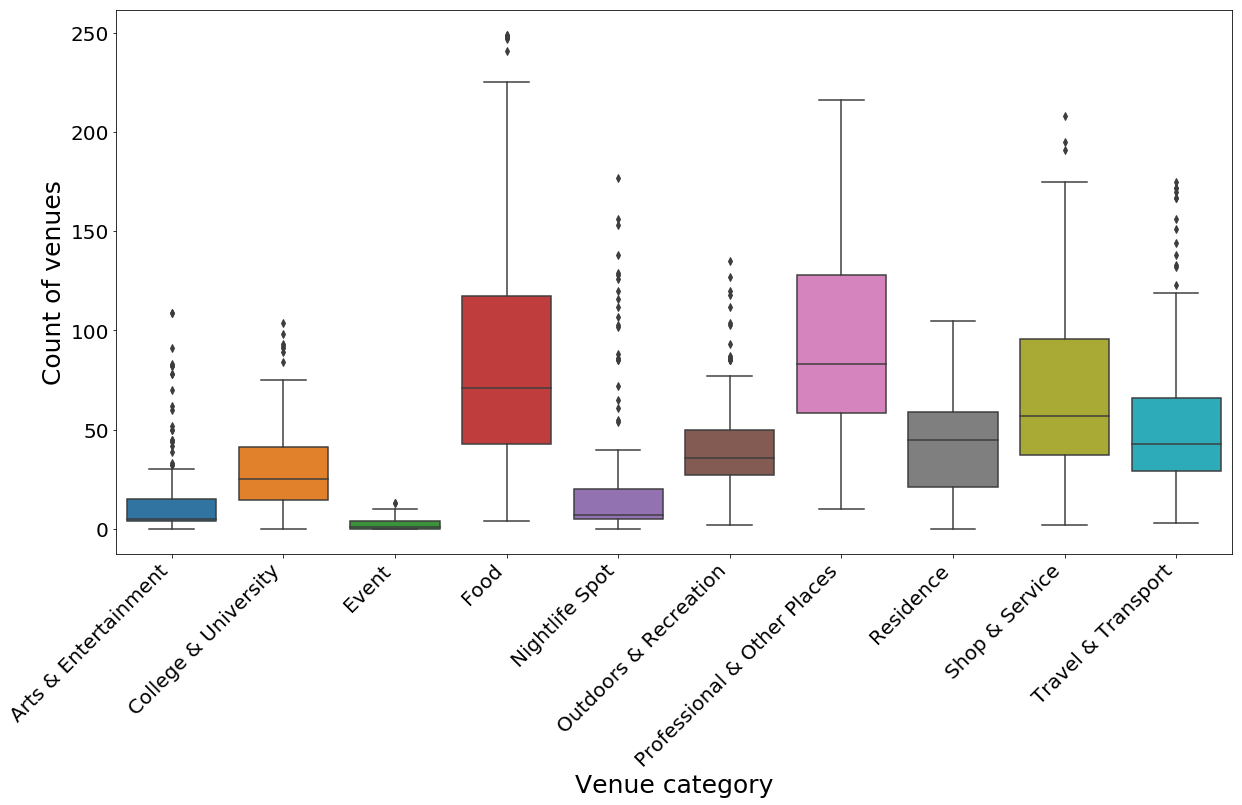

In [27]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot
#dataframe[dataframe.columns[-3:]]
ax = sns.boxplot(data = sub_stations_venues.iloc[:,3:13])
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

### Standardize the data

In [28]:
from sklearn.preprocessing import MinMaxScaler

X = sub_stations_venues.values[:,3:]
cluster_dataset = MinMaxScaler().fit_transform(X)
#cluster_dataset

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.146789,0.096154,0.076923,0.469388,0.152542,0.248120,0.296117,0.123810,0.572816,0.366279
1,0.055046,0.028846,0.000000,0.159184,0.028249,0.135338,0.169903,0.038095,0.053398,0.087209
2,0.137615,0.096154,0.000000,0.138776,0.045198,0.270677,0.281553,0.190476,0.111650,0.151163
3,0.027523,0.009615,0.076923,0.012245,0.028249,0.000000,0.000000,0.000000,0.053398,0.087209
4,0.000000,0.067308,0.000000,0.195918,0.062147,0.097744,0.354369,0.076190,0.097087,0.081395


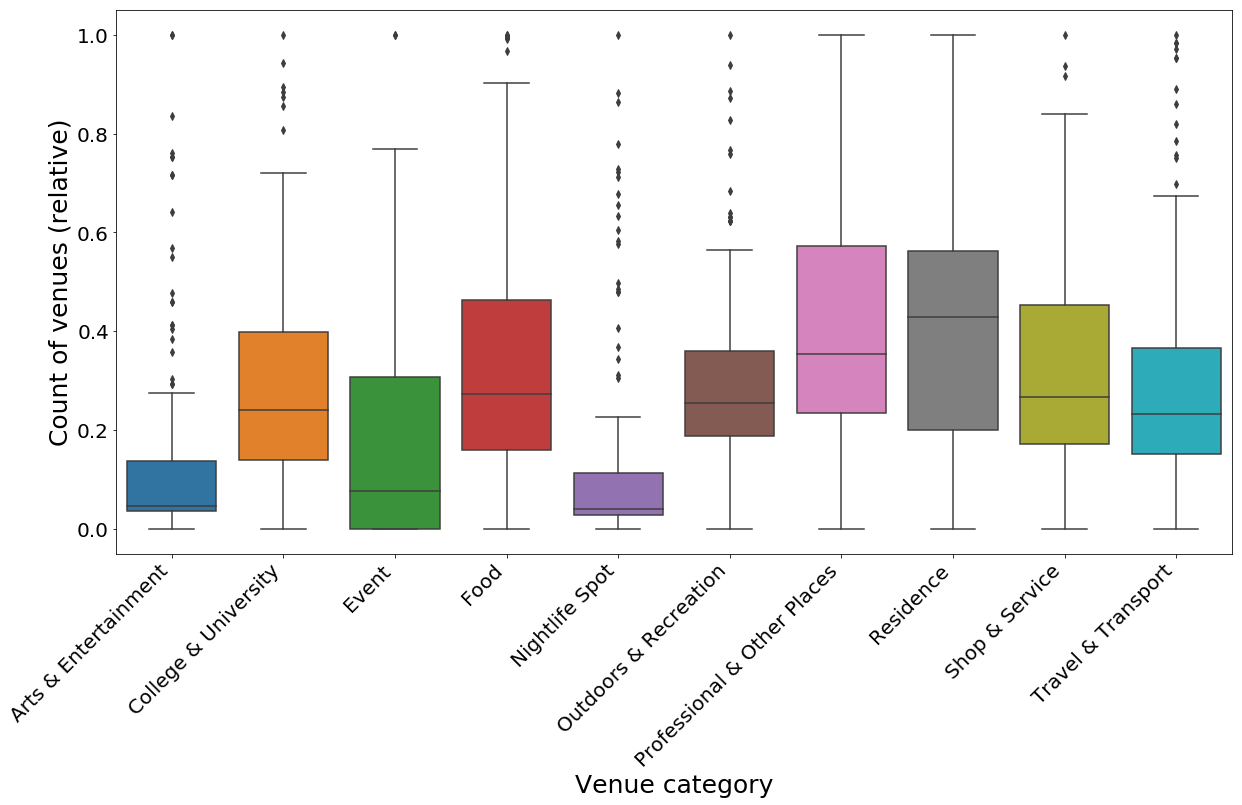

In [30]:
plt.figure(figsize=(20, 10))
sns.boxplot
ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
plt.show()

### Determining optimal number of cluster

In [31]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_df)
    Sum_of_squared_distances.append(km.inertia_)

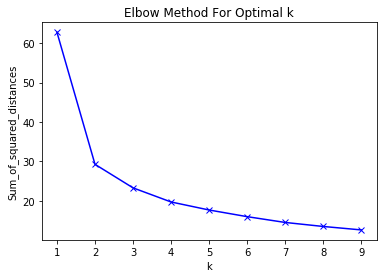

In [32]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### We select k=3 as beyond than any additional cluster will be very similar

# Clustering MRT Stations

In [33]:
# set number of clusters
kclusters = 3
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)
kmeans_labels = kmeans.labels_

In [34]:
# Check the size to ensure all 119 stations are labeled
kmeans_labels.size

119

In [35]:
# add clustering labels
sub_stations_venues.insert(0, 'Cluster Labels', kmeans_labels)
sub_stations_venues.head()

,Cluster Labels,Station Name,Lat,Long,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0,HarbourFront,1.266055,103.819935,16,10,1,119,27,35,71,13,120,66
1,1,Labrador Park,1.266151,103.802741,6,3,0,43,5,20,45,4,13,18
2,1,Telok Blangah,1.270839,103.808725,15,10,0,38,8,38,68,20,25,29
3,1,Marina South Pier,1.270903,103.863195,3,1,1,7,5,2,10,0,13,18
4,1,Pasir Panjang,1.275851,103.792596,0,7,0,52,11,15,83,8,22,17


In [36]:
#cluster_df.drop(axis=0,'Cluster Labels')
cluster_df.insert(0, 'Cluster Labels', kmeans_labels)
cluster_df.head()

,Cluster Labels,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0,0.146789,0.096154,0.076923,0.469388,0.152542,0.248120,0.296117,0.123810,0.572816,0.366279
1,1,0.055046,0.028846,0.000000,0.159184,0.028249,0.135338,0.169903,0.038095,0.053398,0.087209
2,1,0.137615,0.096154,0.000000,0.138776,0.045198,0.270677,0.281553,0.190476,0.111650,0.151163
3,1,0.027523,0.009615,0.076923,0.012245,0.028249,0.000000,0.000000,0.000000,0.053398,0.087209
4,1,0.000000,0.067308,0.000000,0.195918,0.062147,0.097744,0.354369,0.076190,0.097087,0.081395


### Examine each cluster

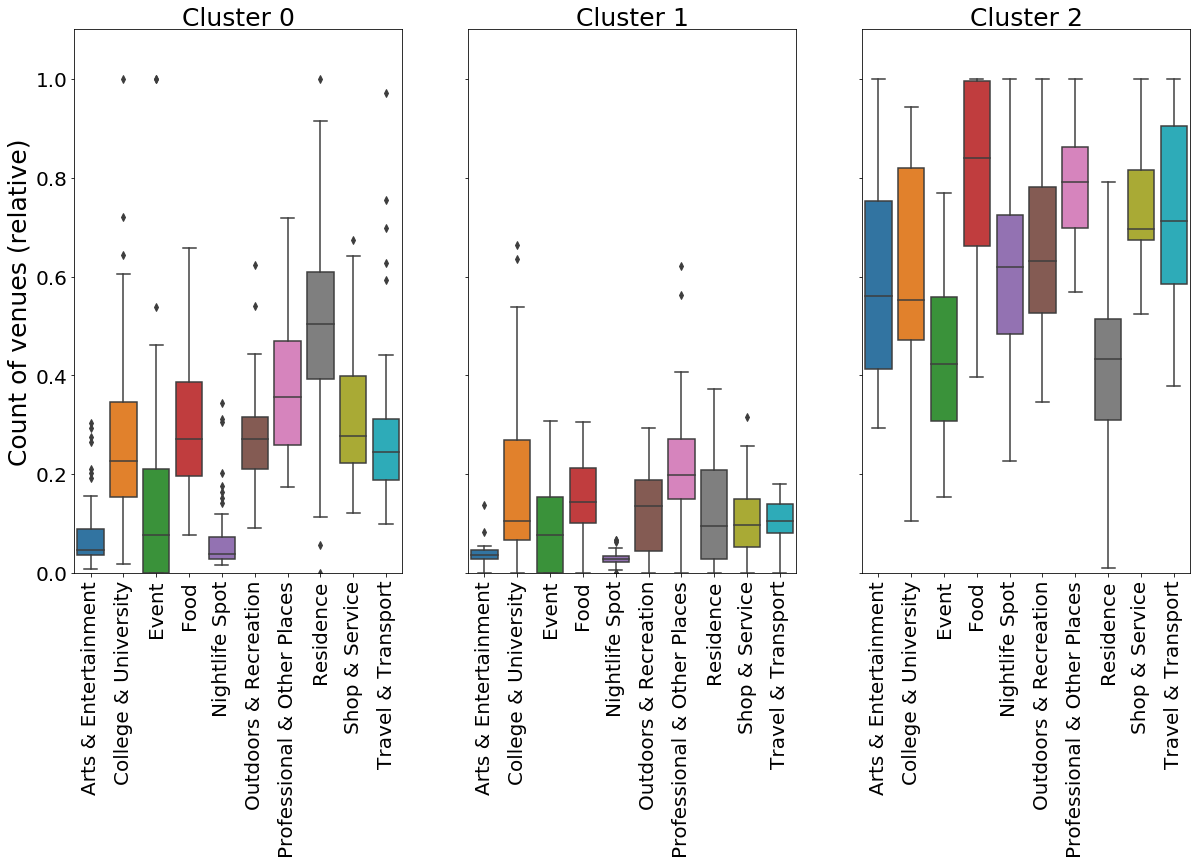

In [37]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)

for k in range(kclusters):
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = cluster_df[cluster_df['Cluster Labels']==k].drop(['Cluster Labels'], axis=1), ax=axes[k])

plt.show()

### Superimposed the clusters on map

In [38]:
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=11,tiles="cartodbpositron")
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sub_stations_venues['Lat'], sub_stations_venues['Long'], sub_stations_venues['Station Name'], sub_stations_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters2)
       
map_clusters2

# Result

From the previous section, we classified the MRT stations into 3 groups based on the venues categories surrounding the stations provided by Foursquare API.

- Cluster 0 (Red): Having significant higher proportion of residential areas, and intermediate rating for rest of the categories.
- Cluster 1 (Purple): Appear to be a less developed area with limited number of places recorded in Foursquare.
- Cluster 2 (Green): Exhibit highest rating in almost all types of venues.

By visuallizing the clusters on map, it's now making more sense that:

- Cluster 0: Belong to typical developed HDB estates (Singapore public housing), typically with one or more shopping malls.
- Cluster 1: Are mostly less populated areas and close to industrial parks or shipping ports.
- Cluster 2: Highly developed, fast-paced, Central Bussiness District, with tourist attractions nearby.


# Discussion

Despite Foursquare provide a fairly comprehensive database to explore the surrouding of any point of interest, but the data may not be able to tell the whole insight about a community. Generally, most of the data are gathered from its users, and we are only able to rely on the sources from a specific group of people who uses Foursquare. Furthermore, due to the preceeding reason, not all venues in the neighbourhood will be capture by Foursquare, as not everyone in Singapore uses the App, and a venus will only be recorded if a Foursquare user posted anything about the place.

# Conclusion

In this project, we successfully clustered all the 119 MRT stations in Singapore into 3 groups: 
1. Housing Estates
2. Sub-urban Industrial Zone
3. Central Bussiness District (i.e. Downtown)

Back to the problem of XYZ Corporation, as most of the Singaporean work in the Central Bussiness District (CBD)(Cluster 2) and live in the Housing Estates (Cluster 0). Therefore, one of the recomendations will be opening their snack bar bussiness in the CBD targeting office workers in the morning peak, and the grocery stores at Housing Estate targeting the same group of people working in CBD who returning to their home at the evening.

# The End